## Webscrapping de Ámbito Financiero

In [110]:
# Manejar el tiempo y contar el tiempo de ejecución
import time
comienzo = time.perf_counter()

# Convertir los datos en DataFrame y transformar
import pandas as pd

# Webscrapping
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# from selenium.webdriver.common.keys import Keys
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

try:
    # Ingresamos a la web de ambito financiero
    driver = webdriver.Chrome("chromedriver", options=chrome_options)
    url = "https://www.ambito.com/contenidos/riesgo-pais-historico.html"
    driver.get(url)

    # Cliquear en donde filtramos fecha de inicio

    filtro_fecha = driver.find_element(
        "xpath",
        "/html/body/main/div/div[1]/div[10]/div[1]/div[1]/input"
    )
    filtro_fecha.click()

    # Limpiamos y ponemos una fecha bien vieja para que nos dé el máximo que pueda
    filtro_fecha.clear()
    filtro_fecha.send_keys("05/06/1995")

    time.sleep(0.5)

    # Ejecutar el botón para filtrar la tabla
    boton_filtrar = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located(
            ("xpath", "/html/body/main/div/div[1]/div[10]/div[1]/button")
        )
    )
    driver.execute_script(
        "arguments[0].click();",
        boton_filtrar)

    # Esperar a que la tabla cargue, sin wait, sino toma los datos antes de que termine de cargar
    time.sleep(3)

    tabla = driver.find_element(
        "xpath",
        "/html/body/main/div/div[1]/div[10]/table")

    # Tomamos el contenido HTML de la tabla
    tabla = tabla.get_attribute("outerHTML")

    # Desde el HTML creamos el dataframe
    riesgo_pais_df = pd.read_html(tabla)[0]
    riesgo_pais_df["Fecha"] = pd.to_datetime(
        riesgo_pais_df['Fecha'],
        dayfirst=True)
    riesgo_pais_df["Puntos"] = riesgo_pais_df["Puntos"] // 100

# Cerramos el navegador
finally:
    driver.quit()

# Exportamos a Excel
riesgo_pais_df.to_excel("Riesgo País.xlsx")

print(
    f"""
La duración de la ejecución total fue de: {time.perf_counter() - comienzo:.2f} segundos.
{riesgo_pais_df}""")


La duración de la ejecución total fue de: 14.91 segundos.
          Fecha  Puntos
0    2023-06-20    2356
1    2023-06-19    2371
2    2023-06-16    2371
3    2023-06-15    2359
4    2023-06-14    2330
...         ...     ...
6323 1998-12-17     758
6324 1998-12-16     760
6325 1998-12-15     734
6326 1998-12-14     766
6327 1998-12-11     720

[6328 rows x 2 columns]


## Gráfico Histórico

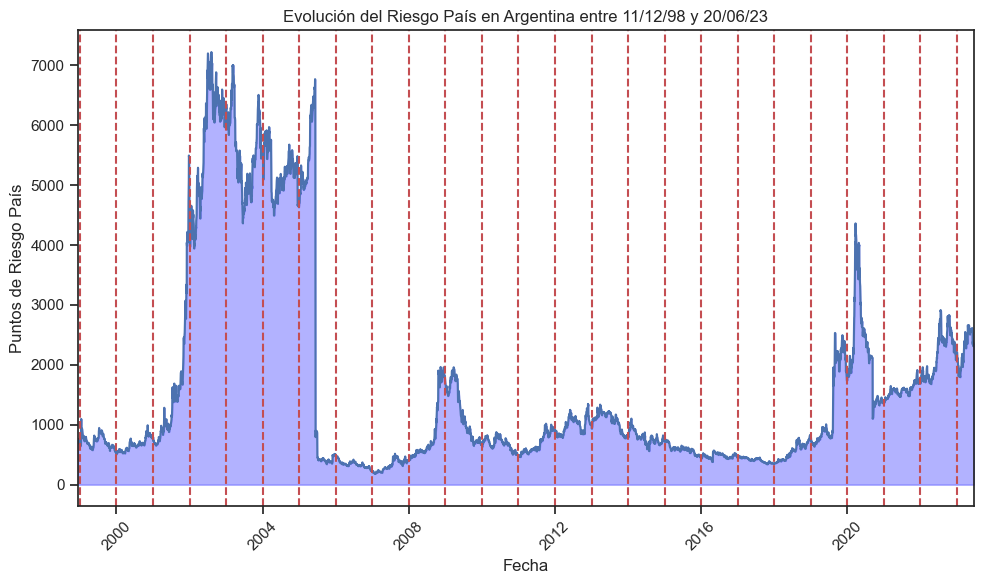

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

# Formatear fechas y puntos
riesgo_pais_df['Fecha'] = pd.to_datetime(riesgo_pais_df['Fecha'])
riesgo_pais_df['Puntos'] = pd.to_numeric(riesgo_pais_df['Puntos'])

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(10, 6))
sns.set(style="ticks")

# Graficar línea
sns.lineplot(data=riesgo_pais_df, x='Fecha', y='Puntos', color='b', ax=ax)
fecha_min = riesgo_pais_df['Fecha'].min()
fecha_max = riesgo_pais_df['Fecha'].max()

# Configurar ejes
ax.set_xlabel('')
ax.set_ylabel('Puntos Base')
ax.set_title(f'Evolución del Riesgo País en Argentina entre {fecha_min.strftime("%d/%m/%y")} y {fecha_max.strftime("%d/%m/%y")}')

# Agregar líneas verticales punteadas rojas en el primer día del primer mes de cada año
for year in range(riesgo_pais_df['Fecha'].min().year, riesgo_pais_df['Fecha'].max().year + 2):
    date = pd.to_datetime(f'01/01/{year}', format='%d/%m/%Y')
    ax.axvline(date, color='r', linestyle='--')        

# Ajustamos los límites
ax.set_xlim(fecha_min, fecha_max)
    
# Rotar etiquetas del eje X para mayor legibilidad
plt.xticks(rotation=45)

# Rellenamos el espacio hacia abajo
plt.fill_between(riesgo_pais_df["Fecha"], riesgo_pais_df["Puntos"], color="blue", alpha=0.3)

# Mostrar gráfico
plt.tight_layout()
plt.show()

## Gráficos Históricos divididos por año

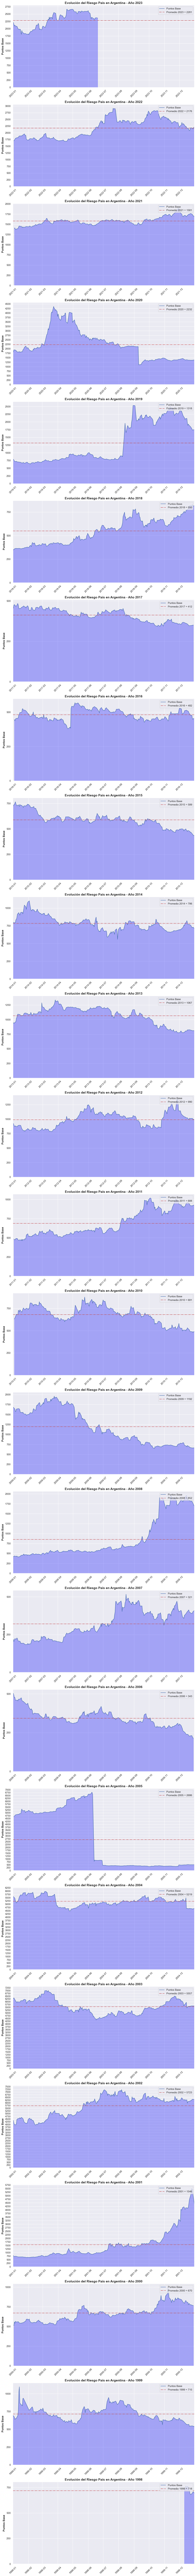

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

# Formatear fechas y puntos
riesgo_pais_df['Fecha'] = pd.to_datetime(
    riesgo_pais_df['Fecha'],
    dayfirst=True)

# Obtener los años únicos en el DataFrame
años = riesgo_pais_df['Fecha'].dt.year.unique()

# Crear figura y subplots por año
fig, axs = plt.subplots(nrows=len(años), ncols=1, figsize=(12, len(años) * 6), sharex=False)
sns.set(style="darkgrid")

# Iterar sobre los subplots y los años correspondientes
for ax, year in zip(axs, años):
    # Filtrar los datos por año
    df_year = riesgo_pais_df[riesgo_pais_df['Fecha'].dt.year == year]
    
    # Graficar línea
    sns.lineplot(data=df_year, x='Fecha', y='Puntos', color='b', ax=ax, label='Puntos Base')
        
    # Establecer límites del eje X según el mínimo y el máximo de la fecha correspondiente
    ax.set_xlim(pd.to_datetime(f'01/01/{year}', format='%d/%m/%Y'), pd.to_datetime(f'31/12/{year}', format='%d/%m/%Y'))
    
    # Configurar límites y ticks del eje Y
    ax.set_ylim(0, df_year['Puntos'].max() * 1.05) 
    ax.yaxis.set_major_locator(plt.MultipleLocator(250))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(50))
    
    # Agregar línea horizontal del promedio del año
    ax.axhline(df_year['Puntos'].mean(), color='r', linestyle='-.', label=f"Promedio {year} = {df_year['Puntos'].mean():.0f}")
    
    # Configurar títulos de ejes
    ax.set_xlabel('')  
    ax.set_ylabel('Puntos Base', fontweight='bold')
    
    # Ajustar título del gráfico en negrita y con un poco más de tamaño
    ax.set_title(f'Evolución del Riesgo País en Argentina - Año {year}', fontweight='bold', fontsize=14)
    
    # Leyenda
    ax.legend(loc='upper right')
    
    # Rellenar el área hacia abajo
    ax.fill_between(df_year['Fecha'], df_year['Puntos'], color='blue', alpha=0.3)

    # Rotar etiquetas del eje X para mayor legibilidad
    ax.tick_params(axis='x', rotation=45)

# Ajustar espaciado vertical entre subplots
plt.subplots_adjust(hspace=0.5)

# Mostrar gráfico
plt.tight_layout()
plt.show()